# Исследование данных мобильного приложения

**Описание проекта**

Стартап продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.

Нужно изучить воронку продаж и исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нужно выяснить, какой шрифт лучше.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие.

* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Примерный план действий**

1. Открыть файл с данными и изучить общую информацию
2. Подготовить данные
3. Изучить и проверить данные
* Сколько всего событий в логе?
* Сколько всего пользователей в логе?
* Сколько в среднем событий приходится на пользователя?
* Данными за какой период мы располагаем? Определить, с какого момента данные полные и отбросить более старые.
* Много ли событий и пользователей мы потеряли, отбросив старые данные?
* Проверить, что есть пользователи из всех трёх экспериментальных групп.
4. Изучить воронку событий
* Посмотреть, какие события есть в логах, как часто они встречаются.
* Посчитать, сколько пользователей совершали каждое из этих событий.
* Предположить, в каком порядке происходят события.
* По воронке событий посчитать, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).
* На каком шаге теряем больше всего пользователей?
* Какая доля пользователей доходит от первого события до оплаты?
5. Изучить результаты эксперимента
* Сколько пользователей в каждой экспериментальной группе?
* Проверить, находят ли статистические критерии разницу между 2 контрольными выборками.
* Проверить, находят ли статистические критерии разницу между выборками контрольными и экспериментальной.
* Какой уровень значимости выбрать при проверке статистических гипотез выше?

## Открываем файл с данными и изучаем общую информацию

Импортируем библиотеки.

In [1]:
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy import stats as st
import math as mth

Загрузим данные из CSV-файла в переменную.

In [2]:
logs = pd.read_csv('logs_exp.csv', sep='\t')

Изучим данные. Для начала выведем первые 20 строчек датафрейма на экран.

In [3]:
display(logs.head(20))

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Выведем основную информацию о датафрейме.

In [4]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод**: нужно заменить названия столбцов. Пропусков нет. В столбце `EventTimestamp` нужно изменить числовой тип данных на тип времени.

## Подготовим данные

* Заменим названия столбцов, чтобы они не содержали заглавных букв, а содержали нижние подчеркивания.

In [5]:
logs = logs.rename(columns={'EventName':'event_name', 'DeviceIDHash': 'device_id_hash', 'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'})

* Изменим тип данных в столбце `event_timestamp` с числового на тип времени.

In [6]:
logs['event_timestamp'] = pd.to_datetime(logs['event_timestamp'], unit='s')

* Добавим отдельный столбец дат.

In [7]:
logs['date'] = pd.DatetimeIndex(logs['event_timestamp']).date

Проверим наличие дубликатов.

In [8]:
logs.duplicated().sum()

413

Есть полные дубликаты строк, посмотрим на них.

In [9]:
logs.loc[logs.duplicated()].sort_values('event_timestamp')

,event_name,device_id_hash,event_timestamp,exp_id,date
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247,2019-08-01
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248,2019-08-01
...,...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,247,2019-08-07
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,247,2019-08-07
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07


Похоже произошли ошибки при логировании данных. Удалим дубликаты.

In [10]:
logs = logs.drop_duplicates().reset_index()

Проверим данные на неполные дубликаты. Посмотрим, есть ли строки в датафрейме с одинаковыми названием события, идентификатором пользователя и временем события.

In [11]:
logs.duplicated(subset=['event_name', 'device_id_hash', 'event_timestamp']).sum()

0

Таких дубликатов нет.

Проверим, нет ли попадания пользователей сразу в несколько групп.

In [12]:
users_groups = logs.groupby('device_id_hash').agg({'exp_id': 'nunique'})
users_groups.loc[users_groups['exp_id'] != 1].count()

exp_id    0
dtype: int64

Таких пользователей нет.

**Вывод**: данные готовы для исследований.

## Изучим и проверим данные

* Определим, сколько всего событий в логе.

In [13]:
events = logs['event_name'].count()
events

243713

In [14]:
logs['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

**Вывод**: всего в логе около 244 тыс. событий 5 типов.

* Определим, сколько всего пользователей в логе.

In [15]:
users = len(logs['device_id_hash'].unique())
users

7551

**Вывод**: в логе 7,5 тыс. пользователей.

* Определим, сколько в среднем событий приходится на пользователя.

In [16]:
logs.groupby('device_id_hash')['event_name'].count().mean()

32.27559263673685

Изучим распределение кол-ва событий на пользователей.

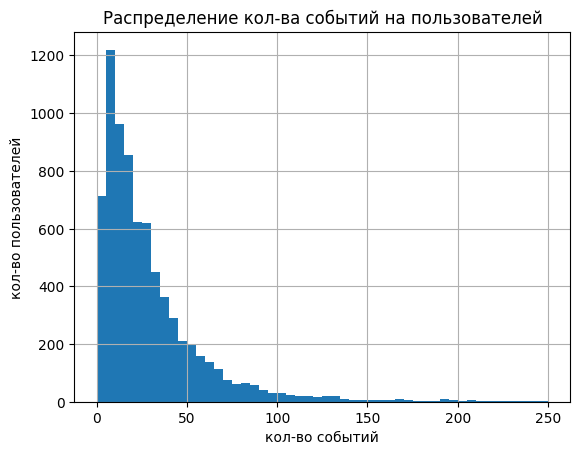

In [17]:
logs.groupby('device_id_hash')['event_name'].count().hist(range=(0, 250), bins=50)
plt.title('Распределение кол-ва событий на пользователей')
plt.xlabel('кол-во событий')
plt.ylabel('кол-во пользователей')
plt.show()

**Вывод**: на каждого пользователя в среднем приходится 32 события. По гистограмме наблюдаем пик около 5-10 событий. Очень мало значений после 150.

* Определим, данными за какой период мы располагаем.

In [18]:
print('Максимальная дата - ', logs['date'].max())
print('Минимальная дата - ', logs['date'].min())

Максимальная дата -  2019-08-07
Минимальная дата -  2019-07-25


Соответственно располагаем данными за 2 недели. Изучим, как меняется количество данных во времени.

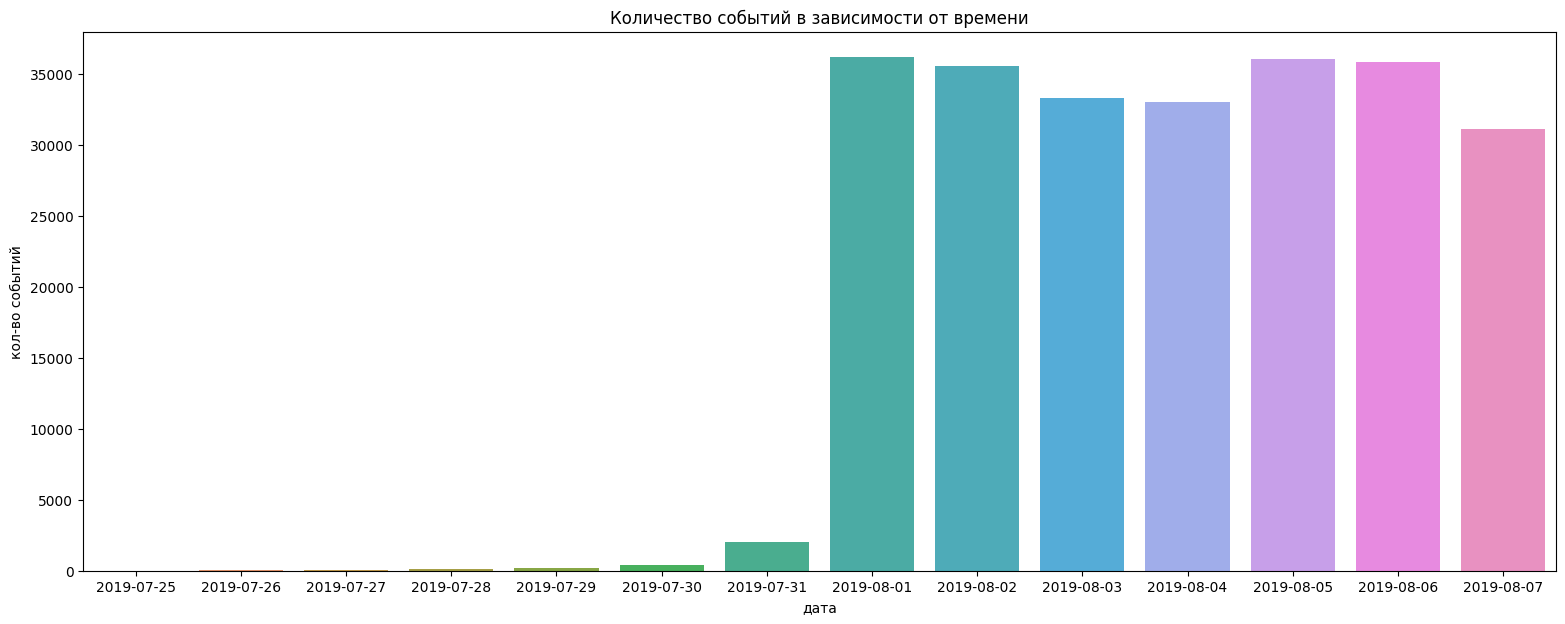

In [19]:
matplotlib.rcParams['figure.figsize'] = [19,7]
logs_date = logs.groupby('date')['event_name'].count()
seaborn.barplot(x=logs_date.index, y=logs_date)
plt.title('Количество событий в зависимости от времени')
plt.xlabel('дата')
plt.ylabel('кол-во событий')
plt.show()

Видим, что у нас данные неодинаково полные за весь период. С 1 августа данные полные, оставим их, а остальные отбросим.

In [20]:
logs = logs.loc[logs['date'] >= pd.to_datetime('2019-08-01')]

<ipython-input-20-d29b3aff348d>:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  logs = logs.loc[logs['date'] >= pd.to_datetime('2019-08-01')]


**Вывод**: на самом деле мы располагаем данными за 1 неделю.

* Проверим, сколько событий и пользователей мы потеряли, отбросив старые данные.

In [21]:
print('Потеряли', events - logs['event_name'].count(), 'событий, что составляет', round((events - logs['event_name'].count())/events, 2), 'от первоначального количества.')

Потеряли 2826 событий, что составляет 0.01 от первоначального количества.


In [22]:
users2 = len(logs['device_id_hash'].unique())
print('Потеряли', users - users2, 'пользователей, что составляет', round((users - users2)/users, 3), 'от первоначального количества.')

Потеряли 17 пользователей, что составляет 0.002 от первоначального количества.


**Вывод**: мы потеряли около 1% событий и менее 1% пользователей. Соответственно, потери совсем незначительны.

* Проверим, что у нас есть пользователи из всех трех экспериментальных групп.

In [23]:
logs['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

**Вывод**: у нас есть пользователи из всех трех экспериментальных групп.

## Изучим воронку событий

* Посмотрим, какие события есть в логах и как часто они встречаются.

In [24]:
events_count = logs['event_name'].value_counts()
events_count

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

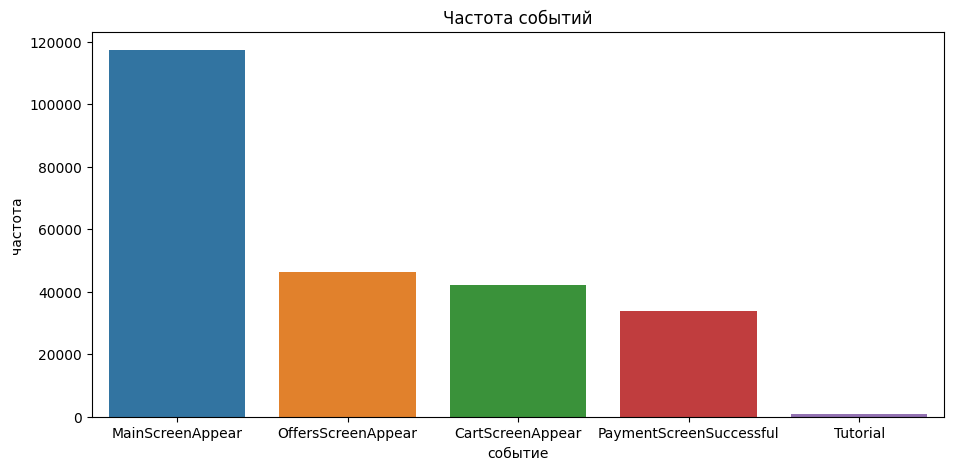

In [25]:
matplotlib.rcParams['figure.figsize'] = [11,5]
seaborn.barplot(x=events_count.index, y=events_count)
plt.title('Частота событий')
plt.xlabel('событие')
plt.ylabel('частота')
plt.show()

**Вывод**: в логах имеем следующие события: появление главного экрана, появление экрана предложений, появление экрана корзины, успешное прохождение оплаты и руководство. Наибольшую частоту имеет событие "появление главного экрана", а наименьшую частоту - "руководство".

* Посчитаем, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие.

In [26]:
events_users = logs.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)
events_users['share'] = round(events_users['device_id_hash'] / users2, 2)
events_users

,device_id_hash,share
event_name,,
MainScreenAppear,7419,0.98
OffersScreenAppear,4593,0.61
CartScreenAppear,3734,0.50
PaymentScreenSuccessful,3539,0.47
Tutorial,840,0.11


**Вывод**: видим, что событие "появление главного экрана" совершали почти все пользователи, а до события "успешное прохождение оплаты" доходит меньше половины пользователей. Интересно, что около 2% пользователей миновали главный экран. Очевидно, перед главным экраном может появиться другой экран. По данным предполагаем, что это руководство, которое можно пройти по желанию и на любом этапе. То есть руководство появляется перед главным экраном, и 2% пользователей заканчивают на нем свое взаимодействие с приложением, не переходя к главному экрану.

* Можно предположить, что события происходят в следующем порядке:
1. появление главного экрана
2. появление экрана предложений
3. появление экрана корзины
4. успешное прохождение оплаты

Только событие "руководство" не встраивается в последовательную цепочку. Не будем его учитывать при расчете воронки.

* По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки.

In [27]:
events_users['conversion'] =  round(events_users['device_id_hash'].pct_change() + 1, 2)
events_users

,device_id_hash,share,conversion
event_name,,,
MainScreenAppear,7419,0.98,NaN
OffersScreenAppear,4593,0.61,0.62
CartScreenAppear,3734,0.50,0.81
PaymentScreenSuccessful,3539,0.47,0.95
Tutorial,840,0.11,0.24


* Видим, что больше всего пользователей теряем на шаге между появлением главного экрана и появлением экрана предложений.

* Посчитаем, какая доля пользователей доходит от первого события до оплаты.

In [28]:
print('Доля пользователей, которая доходит от первого события до оплаты = ', round(events_users.loc['PaymentScreenSuccessful', 'device_id_hash'] / events_users.loc['MainScreenAppear', 'device_id_hash'], 2))

Доля пользователей, которая доходит от первого события до оплаты =  0.48


**Вывод**: от первого события до оплаты доходит меньше половины пользователей.

**Общий вывод**: пользователи доходят до покупки по пути: гланый экран -> экран предложений -> корзина -> оплата. До покупки доходит 48% пользователей. 37% пользователей застревает на шаге "появление главного экрана", 11% - на шаге "появление экрана предложений", 3% - на шаге "появление экрана корзины".

## Изучим результаты эксперимента

* Посчитаем, сколько пользователей в каждой экспериментальной группе.

In [29]:
logs.groupby('exp_id').agg({'device_id_hash': 'nunique'})

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


**Вывод**: разница кол-ва пользователей в экспериментальных группах незначительна.

* Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Напишем функцию для проверки отличия между группами на статистическую достоверность. Нулевая гипотеза: между долями есть значимая разница. Альтернативная гипотеза: между долями нет значимой разницы. Выбираем уровнем статистической значимости 0.05. Используем z-тест для долей.

In [30]:
def check(event, group1, group2):

    alpha = 0.05  # критический уровень статистической значимости

    events = np.array([
        logs.query('event_name == @event and exp_id == @group1')['device_id_hash'].nunique(),
        logs.query('event_name == @event and exp_id == @group2')['device_id_hash'].nunique()
    ])
    visitors = np.array([
        logs.query('exp_id == @group1')['device_id_hash'].nunique(),
        logs.query('exp_id == @group2')['device_id_hash'].nunique()
    ])

    p1 = events[0]/visitors[0]

    p2 = events[1]/visitors[1]

    p_combined = (events[0] + events[1]) / (visitors[0] + visitors[1])

    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/visitors[0] + 1/visitors[1]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями по', event, 'в группах', group1, 'и', group2, 'есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по ', event, 'в группах', group1, 'и', group2, 'разными'
        )

Применим функцию для всех событий.

In [31]:
check('MainScreenAppear', 246, 247)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  MainScreenAppear в группах 246 и 247 разными


In [32]:
check('OffersScreenAppear', 246, 247)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  OffersScreenAppear в группах 246 и 247 разными


In [33]:
check('CartScreenAppear', 246, 247)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  CartScreenAppear в группах 246 и 247 разными


In [34]:
check('PaymentScreenSuccessful', 246, 247)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  PaymentScreenSuccessful в группах 246 и 247 разными


**Вывод**: можно сказать, что разбиение на группы работает корректно. Можно приступать к А/В тесту.

* Сравним группу с измененным шрифтом с каждой из контрольных групп в отдельности по каждому событию.

In [35]:
check('MainScreenAppear', 246, 248)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  MainScreenAppear в группах 246 и 248 разными


In [36]:
check('OffersScreenAppear', 246, 248)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  OffersScreenAppear в группах 246 и 248 разными


In [37]:
check('CartScreenAppear', 246, 248)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  CartScreenAppear в группах 246 и 248 разными


In [38]:
check('PaymentScreenSuccessful', 246, 248)

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  PaymentScreenSuccessful в группах 246 и 248 разными


In [39]:
check('MainScreenAppear', 247, 248)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  MainScreenAppear в группах 247 и 248 разными


In [40]:
check('OffersScreenAppear', 247, 248)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  OffersScreenAppear в группах 247 и 248 разными


In [41]:
check('CartScreenAppear', 247, 248)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  CartScreenAppear в группах 247 и 248 разными


In [42]:
check('PaymentScreenSuccessful', 247, 248)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  PaymentScreenSuccessful в группах 247 и 248 разными


Сравним результаты с объединённой контрольной группой. Создадим функцию check_pooled.

In [43]:
def check_pooled(event):

    alpha = 0.05  # критический уровень статистической значимости

    events = np.array([
        logs.query('event_name == @event and exp_id != 248')['device_id_hash'].nunique(),
        logs.query('event_name == @event and exp_id == 248')['device_id_hash'].nunique()
    ])
    visitors = np.array([
        logs.query('exp_id != 248')['device_id_hash'].nunique(),
        logs.query('exp_id == 248')['device_id_hash'].nunique()
    ])

    p1 = events[0]/visitors[0]

    p2 = events[1]/visitors[1]

    p_combined = (events[0] + events[1]) / (visitors[0] + visitors[1])

    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/visitors[0] + 1/visitors[1]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями по', event, 'в группах объединенной контрольной и экспериментальной есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по ', event, 'в группах объединенной контрольной и экспериментальной разными'
        )

In [44]:
check_pooled('MainScreenAppear')

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  MainScreenAppear в группах объединенной контрольной и экспериментальной разными


In [45]:
check_pooled('OffersScreenAppear')

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  OffersScreenAppear в группах объединенной контрольной и экспериментальной разными


In [46]:
check_pooled('CartScreenAppear')

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  CartScreenAppear в группах объединенной контрольной и экспериментальной разными


In [47]:
check_pooled('PaymentScreenSuccessful')

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли по  PaymentScreenSuccessful в группах объединенной контрольной и экспериментальной разными


**Вывод**: по результатам A/A/B-эксперимента не выявленно ни положительного, ни отрицательного влияния шрифтов.

* При проверке статистических гипотез выше был выбран уровень значимости в 0.05. Было сделано 12 проверок статистических гипотез. При уровне значимости 0.05 в 5% случаев т.е. в 0.6 гипотезах из 12 можно ошибочно отклонить нулевую гипотезу при условии, что она верна.

## Выводы

В процессе исследования данных мобильного приложения изучена общая информация о данных, осуществлена их подготовка и проверка. Изучена воронка событий и результаты A/A/B-эксперимента о смене шрифтов. Такие выводы получены:
* Пользователи доходят до покупки по пути: появление главного экрана-> появление экрана предложений -> появление экрана корзины -> успешное прохождение оплаты.
* До покупки доходит 48% пользователей.
* На шаге "появление главного экрана" застревает 37% пользователей, на шаге "появление экрана предложений" - 11%, на шаге "появление экрана корзины" - 3%. Больше всего пользователей теряем на шаге между появлением главного экрана и появлением экрана предложений.
* По результатам A/A/B-эксперимента не выявленно ни положительного, ни отрицательного влияния шрифтов. Т.е., их можно менять, можно оставлять - на продажах это не скажется. Исходя из изначальной цели теста – проверить не "испугались" ли пользователи новых шрифтов, можно признать его успешным.